In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
tol = 1e-9
iter_max=1000
a=1 
x=np.array([1.2,1.2] )#-1.2 #1
# parameters for backtracking line search
c = 0.1;
rho = 0.9;

In [3]:


def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p

In [4]:
def modified_cholesky(B):
    """
    Ensure B is symmetric positive definite by adding a small multiple of the identity matrix.
    """
    lambda_min = 1e-4  # Initial small regularization parameter
    max_iter = 100
    for i in range(max_iter):
        try:
            L = np.linalg.cholesky(B + lambda_min * np.eye(B.shape[0]))
            # print(B.shape)
            return B + lambda_min * np.eye(B.shape[0])
        except np.linalg.LinAlgError:
            lambda_min *= 10  # Increase lambda_min until B is SPD
    raise ValueError("Unable to make B SPD after maximum iterations")

In [5]:
def hess(x):
    x1 = x[0]
    x2 = x[1]
    H = np.array([[1200*x1**2-400*x2+2,-400*x1],[-400*x1,200]])
    return H

def pot(x):
    x1 = x[0]
    x2 = x[1]
    f = 100*(x2-x1**2)**2+(1-x1)**2
    return f

def grad(x):
    x1 = x[0]
    x2 = x[1]
    g = np.array([400*x1**3-400*x1*x2+2*x1-2,200*(x2-x1**2)])
    return g

In [6]:
    # the main trust-region cycle
def descend(x, direction):
        #todo move all the initialization inside
        tol = 1e-6 # stop iterations when ||grad f|| < tol
        iter_max = 200 # the maximal number of iterations
        draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
        # parameters for trust region
        Delta_max = 5 # the max trust-region radius
        Delta_min = 1e-12 # the minimal trust-region radius
        Delta = 1 # the initial radius
        eta = 0.1 # step rejection parameter
        subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
        tol_sub = 1e-1 # relative tolerance for the subproblem
        rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
        rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius
        f = pot(x)
        g = grad(x)
        x_old=np.zeros(len(x))
        g_old=np.zeros(len(g))
        B=np.eye(len(x))
        
        norm_g = np.linalg.norm(g)
        print("Initially, f = ",f,", ||grad f|| = ",norm_g)
        
        fvals = np.zeros(iter_max)
        fvals[0] = f
        ngvals = np.zeros(iter_max)
        ngvals[0] = norm_g
        # avals=np.zeros(iter_max)
        # avals[0] = 1 #fix this awful hardcoding
        xvals = np.zeros((iter_max,len(x)))
        xvals[0] = x
        Delta = 1 # the initial trust region radius
        I = np.eye(np.size(x),dtype = float)
        
        itr = 1
    
        while (norm_g > tol and itr < iter_max):      
            # solve the constrained minimization problem 
            if direction=='Newton':
                subproblem_method='exact'
                B = hess(x)
            elif direction=='BFGS':
                subproblem_method='dogleg'
                s=x-x_old
                y=g-g_old
                B=B-(np.outer(B.dot(s),B.dot(s)))/(s.dot(B).dot(s) + 0)+(np.outer(y,y))/(y.dot(s))# +1e-12)
            
            
            flag_boundary = 0 
            # check if B is SPD
            eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
            j_sub = 0
            if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g 
                if subproblem_method=='exact':
                    p = scipy.linalg.solve(B,-g)
                    p_norm = np.linalg.norm(p)
                    if( p_norm > Delta ): # else: we are done with solbing the subproblem
                        flag_boundary = 1    
                if subproblem_method=='dogleg':
                    p_u = cauchy_point(B,g,Delta)
                    p_b = scipy.linalg.solve(B,-g)
                    if np.linalg.norm(p_b) <= Delta:
                        p=p_b
                    elif np.linalg.norm(p_u) >= Delta:
                        p=Delta*p_u/np.linalg.norm(p_u)
                    else:
                        p_diff = p_b - p_u
                        a = np.dot(p_diff, p_diff)
                        b = 2 * np.dot(p_u, p_diff)
                        c = np.dot(p_u, p_u) - Delta**2
                    
                        discr = b**2 - 4 * a * c
                        if discr < 0:
                            t = 0  
                        else:
                            t = (-b + np.sqrt(discr)) / (2 * a)
                        p = p_u + t * p_diff
                    p_norm = np.linalg.norm(p)    
                    flag_boundary = 0
                    
                    
            else: #now B is not SPD, so can't just p = solve(B,-g)
                flag_boundary = 1
            
            if( flag_boundary == 1 ): # solution lies on the boundary
                lam_min = np.maximum(-eval_min,0.0)
                lam = lam_min + 1
                R = scipy.linalg.cholesky(B+lam*I,lower = False)
                flag_subproblem_success = 0;
                while( j_sub < subproblem_iter_max ):
                    j_sub = j_sub + 1;
                    p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
                    p = scipy.linalg.solve_triangular(R,p,lower = False)
                    p_norm = np.linalg.norm(p)
                    dd = np.absolute(p_norm - Delta)
                    if( dd < tol_sub*Delta ):
                        flag_subproblem_success = 1
                        break
                    q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
                    q_norm = np.linalg.norm(q);
                    dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
                    lam_new = lam + dlam;
                    if (lam_new > lam_min):
                        lam = lam_new
                    else:
                        lam = 0.5*(lam + lam_min)
                    R = scipy.linalg.cholesky(B+lam*I,lower = False)
                if( flag_subproblem_success == 0 ):
                    p = cauchy_point(B,g,Delta)
            # assess the progress
            
            xnew = x + p
            fnew = pot(xnew)
            gnew = grad(xnew)
            mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
            rho = (f - fnew)/(f - mnew+1e-14)
            # adjust the trust region
            if( rho < rho_bad ):
                Delta = np.maximum(0.25*Delta,Delta_min)
            else:
                #todo if(  rho > rho_good and flag_boundary == 1 ):
                Delta = np.minimum(Delta_max,2*Delta)
            # accept or reject step
            if( rho > eta ):  # accept step   
                x_old=x
                g_old=g
                x = xnew
                f = fnew
                g = gnew
                norm_g = np.linalg.norm(g)
                print(f'Accept: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')#todo {j_sub}')
            else:
                print(f'Reject: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')#todo  {j_sub}')
            # if( itr % 20 == 19):
                # restore all coordinates
                # xyz = LJvector2array(x)
                # drawconf(xyz,0.5*rstar)
            fvals[itr] = f
            ngvals[itr] = norm_g
            xvals[itr] = x
            itr = itr + 1
        return fvals, ngvals, xvals, itr
        


Initially, f =  5.8 , ||grad f|| =  125.16932531574973
Accept: itr 1: f = 0.0383840344, |df| = 3.9982e-01, rho = 1.0001e+00, Delta = 2.0000e+00, j_sub = 0, method = exact
Reject: itr 2: f = 0.0383840344, |df| = 3.9982e-01, rho = -2.7970e+00, Delta = 5.0000e-01, j_sub = 0, method = exact
Reject: itr 3: f = 0.0383840344, |df| = 3.9982e-01, rho = -2.6133e+00, Delta = 1.2500e-01, j_sub = 2, method = exact
Accept: itr 4: f = 0.0229848762, |df| = 1.0333e+00, rho = 9.8797e-01, Delta = 2.5000e-01, j_sub = 1, method = exact
Accept: itr 5: f = 0.0124978085, |df| = 4.7299e+00, rho = 6.0207e-01, Delta = 5.0000e-01, j_sub = 2, method = exact
Accept: itr 6: f = 0.0011464456, |df| = 1.9459e-01, rho = 1.0522e+00, Delta = 1.0000e+00, j_sub = 0, method = exact
Accept: itr 7: f = 0.0001070151, |df| = 4.5929e-01, rho = 9.5822e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
Accept: itr 8: f = 0.0000000962, |df| = 1.6099e-03, rho = 1.0044e+00, Delta = 4.0000e+00, j_sub = 0, method = exact
Accept: itr 9: 

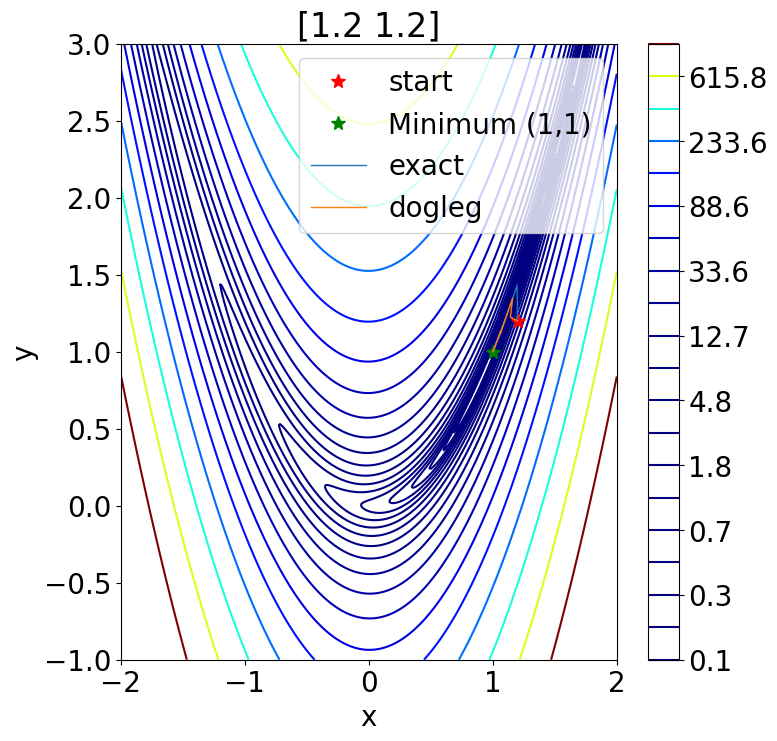

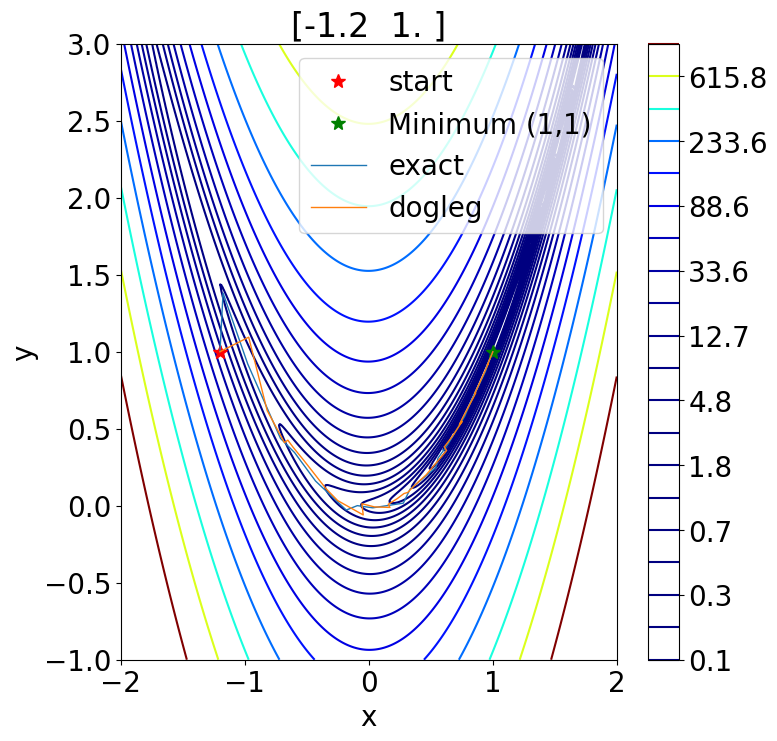

In [7]:
initial_list=np.array([[1.2,1.2],[-1.2,1]])
for idx, initial in enumerate(initial_list):
    x_vals = np.linspace(-2, 2, 400)
    y_vals = np.linspace(-1, 3, 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    def rosenbrock(x, y):
        return (1 - x)**2 + 100 * (y - x**2)**2
    Z = rosenbrock(X, Y) # will this work? no it won't
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    contour = plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap="jet")
    plt.colorbar(contour)
    plt.plot(initial[0], initial[1], 'r*', markersize=10, label="start") #fixme hardcoding intial point
    plt.plot(1, 1, 'g*', markersize=10, label="Minimum (1,1)")
    
    # descend(x,direction=2)
    
    direction_dict = {1:"Newton",2:"BFGS"} #
    plot_dict = {1:"exact",2:"dogleg"} # 
    for direction in direction_dict:
        fvals, ngvals, xvals, itr =descend(initial,direction_dict[direction])
        # print(xvals[:22])
        # Plot the gradient descent path
        plt.plot(xvals[:itr,0],xvals[:itr,1], markersize=3, linewidth=1, label=plot_dict[direction])
    plt.title(f"{initial}")#,{direction_dict[direction]"
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

Initially, f =  5.8 , ||grad f|| =  125.16932531574973
Accept: itr 1: f = 0.0383840344, |df| = 3.9982e-01, rho = 1.0001e+00, Delta = 2.0000e+00, j_sub = 0, method = exact
Reject: itr 2: f = 0.0383840344, |df| = 3.9982e-01, rho = -2.7970e+00, Delta = 5.0000e-01, j_sub = 0, method = exact
Reject: itr 3: f = 0.0383840344, |df| = 3.9982e-01, rho = -2.6133e+00, Delta = 1.2500e-01, j_sub = 2, method = exact
Accept: itr 4: f = 0.0229848762, |df| = 1.0333e+00, rho = 9.8797e-01, Delta = 2.5000e-01, j_sub = 1, method = exact
Accept: itr 5: f = 0.0124978085, |df| = 4.7299e+00, rho = 6.0207e-01, Delta = 5.0000e-01, j_sub = 2, method = exact
Accept: itr 6: f = 0.0011464456, |df| = 1.9459e-01, rho = 1.0522e+00, Delta = 1.0000e+00, j_sub = 0, method = exact
Accept: itr 7: f = 0.0001070151, |df| = 4.5929e-01, rho = 9.5822e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
Accept: itr 8: f = 0.0000000962, |df| = 1.6099e-03, rho = 1.0044e+00, Delta = 4.0000e+00, j_sub = 0, method = exact
Accept: itr 9: 

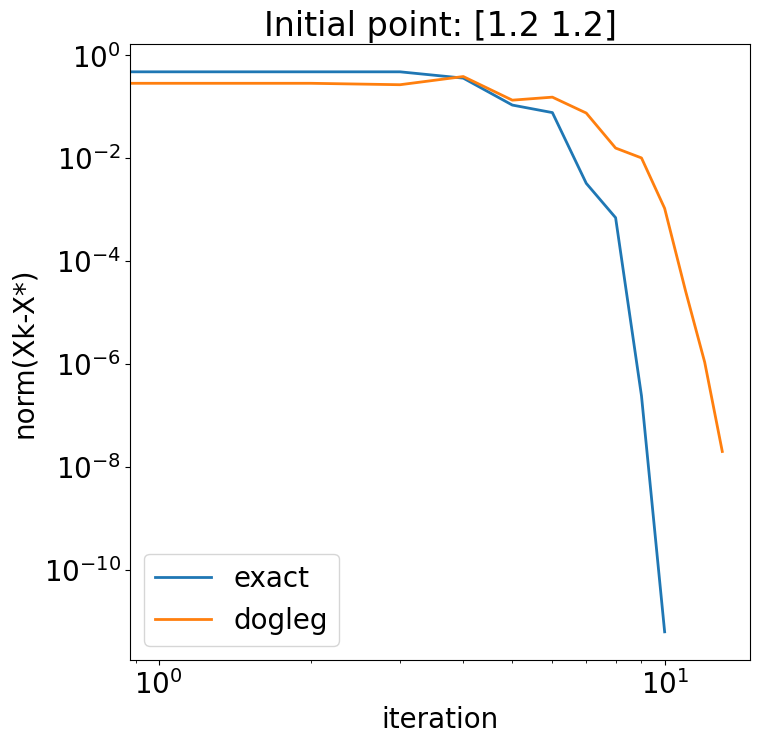

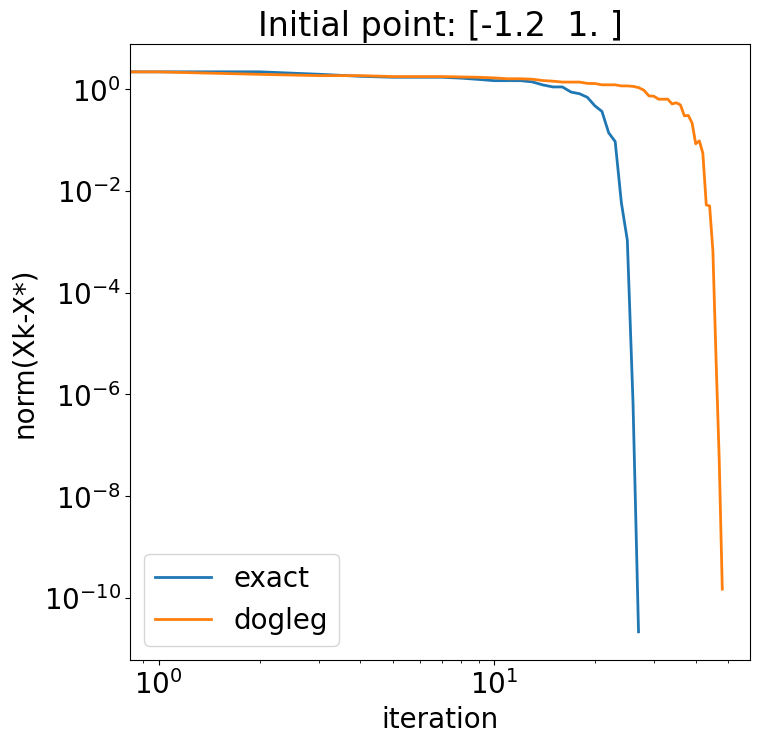

In [8]:
initial_list=np.array([[1.2,1.2],[-1.2,1]])
for idx, initial in enumerate(initial_list):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    direction_dict = {1:"Newton",2:"BFGS"} #
    plot_dict = {1:"exact",2:"dogleg"} # 
    for direction in direction_dict:
        fvals, ngvals, xvals, itr =descend(initial,direction_dict[direction])
        resvals=np.zeros(xvals.shape)
        resvals[:itr,0] = xvals[:itr,0] -1 
        resvals[:itr,1]= xvals[:itr,1]-1
        # print(np.arange(itr).shape,np.linalg.norm(resvals[:itr], axis=1).shape)
        plt.plot(np.arange(itr),np.linalg.norm(resvals[:itr], axis=1),linewidth = 2, label=plot_dict[direction])
        #fixme: deal with zeros() becomeing -1. 
    plt.title(f"Initial point: {initial}")
    plt.xlabel("iteration")
    plt.xscale("log")
    plt.ylabel("norm(Xk-X*)")
    plt.yscale("log")
    plt.legend()